# RNN Classification Model

- Naver 영화 리뷰 데이터를 활용하여 긍정/부정 분류 모델을 만든다

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Download dataset

In [2]:
!git clone https://github.com/e9t/nsmc.git

Cloning into 'nsmc'...
remote: Enumerating objects: 14763, done.
remote: Total 14763 (delta 0), reused 0 (delta 0), pack-reused 14763
Receiving objects: 100% (14763/14763), 56.19 MiB | 22.89 MiB/s, done.
Resolving deltas: 100% (1749/1749), done.
Checking out files: 100% (14737/14737), done.


In [3]:
train_df = pd.read_csv('/content/nsmc/ratings_train.txt',sep='\t', encoding='utf-8')
test_df = pd.read_csv('/content/nsmc/ratings_test.txt',sep='\t', encoding='utf-8')

train_df.dropna(how='any', inplace=True)
test_df.dropna(how='any', inplace=True)

In [ ]:
print(train_df.shape)
print(train_df.head())

(149995, 3)
         id                                           document  label
0   9976970                                아 더빙.. 진짜 짜증나네요 목소리      0
1   3819312                  흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나      1
2  10265843                                  너무재밓었다그래서보는것을추천한다      0
3   9045019                      교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정      0
4   6483659  사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...      1


In [4]:
print(train_df.groupby('label').size())

label
0    75170
1    74825
dtype: int64


In [5]:
train_df = train_df[:5000]
test_df = test_df[:100]

### Preprocess

In [6]:
!pip install hanja
# 형태소 기반 토크나이징 (Konlpy)
!python3 -m pip install konlpy
# mecab (ubuntu, mac 기준)
# 다른 os 설치 방법 및 자세한 내용은 다음 참고: https://konlpy.org/ko/latest/install/#id1
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

import re, hanja
from konlpy.tag import Okt, Komoran, Mecab, Hannanum, Kkma
removal_list =  "‘, ’, ◇, ‘, ”,  ’, ', ·, \“, ·, △, ●,  , ■, (, ), \", >>, `, /, -,∼,=,ㆍ<,>, .,?, !,【,】, …, ◆,%"

EMAIL_PATTERN = re.compile(r'''(([a-zA-Z0-9._%+-]+)@([a-zA-Z0-9.-]+)(\.[a-zA-Z]{2,4}))''', re.VERBOSE)
URL_PATTERN = re.compile("(ftp|http|https)?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", re.VERBOSE)
MULTIPLE_SPACES = re.compile(' +', re.UNICODE)

def get_tokenizer(tokenizer_name):
    if tokenizer_name == "komoran":
        tokenizer = Komoran()
    elif tokenizer_name == "okt":
        tokenizer = Okt()
    elif tokenizer_name == "mecab":
        tokenizer = Mecab()
    elif tokenizer_name == "hannanum":
        tokenizer = Hannanum()
    else:
        tokenizer = Kkma()
        
    return tokenizer

def tokenize(tokenizer_name, original_sent, pos=False):
    tokenizer = get_tokenizer(tokenizer_name)
    sentence = original_sent.replace('\n', '').strip()
    if pos:
        tokens = tokenizer.pos(sentence)
        tokens = [morph + "/" + tag for morph, tag in tokens]
    else:
      # tokenizer.nouns(sentence) -> 명사만 추출
        tokens = tokenizer.morphs(sentence)
        
    # tokenized_sent = ' '.join(post_process(tokens))
    tokenized_sent = ' '.join(tokens)
    
    return tokenized_sent

def cleansing_other(sentence: str = None) -> str:
    """
    문장을 전처리 (이메일, URL, 공백 등 제거) 하는 함수
    :param sentence: 전처리 대상 문장
    :return: 전처리 완료된 문장
    """
    sentence = re.sub(EMAIL_PATTERN, ' ', sentence)
    sentence = re.sub(URL_PATTERN, ' ', sentence)
    sentence = re.sub(MULTIPLE_SPACES, ' ', sentence)
    sentence = sentence.replace(", )", "")
    
    return sentence

def cleansing_chinese(sentence: str = None) -> str:
    """
    한자를 변환하는 전처리를 하는 함수
    :param sentence: 전처리 대상 문장
    :return: 전처리 완료된 문장
    """
    # chinese character를 앞뒤로 괄호가 감싸고 있을 경우, 대부분 한글 번역임
    sentence = re.sub("\([\u2E80-\u2FD5\u3190-\u319f\u3400-\u4DBF\u4E00-\u9FCC\uF900-\uFAAD]+\)", "", sentence)
    # 다른 한자가 있다면 한글로 치환
    if re.search("[\u2E80-\u2FD5\u3190-\u319f\u3400-\u4DBF\u4E00-\u9FCC\uF900-\uFAAD]", sentence) is not None:
        sentence = hanja.translate(sentence, 'substitution')

    return sentence

def cleansing_special(sentence: str = None) -> str:
    """
    특수문자를 전처리를 하는 함수
    :param sentence: 전처리 대상 문장
    :return: 전처리 완료된 문장
    """
    sentence = re.sub("[.,\'\"’‘”“!?]", "", sentence)
    sentence = re.sub("[^가-힣0-9a-zA-Z\\s]", " ", sentence)
    sentence = re.sub("\s+", " ", sentence)
    
    sentence = sentence.translate(str.maketrans(removal_list, ' '*len(removal_list)))
    sentence = sentence.strip()
    
    return sentence

def cleansing_numbers(sentence: str = None) -> str:
    """
    숫자를 전처리(delexicalization) 하는 함수
    :param sentence: 전처리 대상 문장
    :return: 전처리 완료된 문장
    """
    
    sentence = re.sub('[0-9]+', 'NUM', sentence)
    sentence = re.sub('NUM\s+', "NUM", sentence)
    sentence = re.sub('[NUM]+', "NUM", sentence)
    
    return sentence

def preprocess_sent(sentence: str = None) -> str:
    """
    모든 전처리를 수행 하는 함수
    :param sentence: 전처리 대상 문장
    :return: 전처리 완료된 문장
    """
    sent_clean = sentence
    sent_clean = cleansing_other(sent_clean)
    sent_clean = cleansing_chinese(sent_clean)
    sent_clean = cleansing_special(sent_clean)
    sent_clean = cleansing_numbers(sent_clean)
    sent_clean = re.sub('\s+', ' ', sent_clean)
    sent_clean = tokenize('mecab', sent_clean)

    return sent_clean

     |████████████████████████████████| 122kB 9.7MB/s 
     |████████████████████████████████| 266kB 24.1MB/s 
     |████████████████████████████████| 245kB 36.9MB/s 
  Created wheel for hanja: filename=hanja-0.13.2-cp36-none-any.whl size=128339 sha256=c269568d5c4c2780b5c0bd54f6413dcb04924d5bc4a53823170be7167a2b8260
  Stored in directory: /root/.cache/pip/wheels/dc/86/35/26e2202156c2371a71b443de1bab5c957169ee6f1a9eb77c98
  Created wheel for pyyaml: filename=PyYAML-5.1.2-cp36-cp36m-linux_x86_64.whl size=44105 sha256=27abba58ba5e2b54de7ea365c271a67878b6293feb1ddd4d92f63aa1b96ca6a5
  Stored in directory: /root/.cache/pip/wheels/d9/45/dd/65f0b38450c47cf7e5312883deb97d065e030c5cca0a365030
Successfully built hanja pyyaml
ERROR: datascience 0.10.6 has requirement coverage==3.7.1, but you'll have coverage 5.3.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: coveralls 0.5 has requirement coverage<3.999,>

In [7]:
train_df['document'] = train_df['document'].apply(lambda x: preprocess_sent(x))
print(train_df.head())
print(train_df.shape)

         id                                           document  label
0   9976970                               아 더 빙 진짜 짜증 나 네요 목소리      0
1   3819312                흠 포스터 보고 초딩 영화 줄 오버 연기 조차 가볍 지 않 구나      1
2  10265843                                너무 재 밓었다그래서보는것을추천한다      0
3   9045019                      교도소 이야기 구먼 솔직히 재미 는 없 다 평점 조정      0
4   6483659  사이몬페그 의 익살 스런 연기 가 돋보였 던 영화 스파이더맨 에서 늙 어 보이 기 ...      1
(5000, 3)


In [8]:
test_df['document'] = test_df['document'].apply(lambda x: preprocess_sent(x))
print(test_df.head())
print(test_df.shape)

        id                                           document  label
0  6270596                                                  굳      1
1  9274899                        G DNUMTOPCLASSINUMTHECLNUMB      0
2  8544678        뭐 야 이 평점 들 은 나쁘 진 않 지만 NUM 점 짜리 는 더더욱 아니 잖아      0
3  6825595                지루 하 지 는 않 은데 완전 막장 임 돈 주 고 보 기 에 는      0
4  6723715  NUMD 만 아니 었 어도 별 다섯 개 줬 을 텐데 왜 NUMD 로 나와서 제 심기...      0
(100, 3)


In [9]:
X_train = [x.split(' ') for x in train_df['document'].values]
X_test = [x.split(' ') for x in test_df['document'].values]

In [10]:
X_train[:10]

[['아', '더', '빙', '진짜', '짜증', '나', '네요', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍', '지', '않', '구나'],
 ['너무', '재', '밓었다그래서보는것을추천한다'],
 ['교도소', '이야기', '구먼', '솔직히', '재미', '는', '없', '다', '평점', '조정'],
 ['사이몬페그',
  '의',
  '익살',
  '스런',
  '연기',
  '가',
  '돋보였',
  '던',
  '영화',
  '스파이더맨',
  '에서',
  '늙',
  '어',
  '보이',
  '기',
  '만',
  '했',
  '던',
  '커스틴',
  '던스트',
  '가',
  '너무나',
  '도',
  '이뻐',
  '보였',
  '다'],
 ['막',
  '걸음마',
  '뗀',
  'NUM',
  '세',
  '부터',
  '초등',
  '학교',
  'NUM',
  '학년',
  '생',
  '인',
  'NUM',
  '살용',
  '영화',
  '별반',
  '개',
  '도',
  '아까움'],
 ['원작', '의', '긴장감', '을', '제대로', '살려', '내', '지', '못했', '다'],
 ['별',
  '반개',
  '도',
  '아깝',
  '다',
  '욕',
  '나온다',
  '이응경',
  '길용우',
  '연기',
  '생활',
  '이',
  '몇',
  '년',
  '인지',
  '정말',
  '발',
  '로',
  '해도',
  '그것',
  '보단',
  '낫',
  '겟',
  '다',
  '납치',
  '감금',
  '만',
  '반복',
  '반복',
  '이',
  '드라마',
  '는',
  '가족',
  '도',
  '없',
  '다',
  '연기',
  '못',
  '하',
  '는',
  '사람',
  '만',
  '모엿',
  '네'],
 ['액션', '이', '없', '는데', '도'

## Tokenize and preprocess more

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [13]:
tokenizer.word_index

{'이': 1,
 '는': 2,
 '영화': 3,
 '다': 4,
 '고': 5,
 '하': 6,
 '도': 7,
 '가': 8,
 '의': 9,
 '은': 10,
 '을': 11,
 '에': 12,
 'num': 13,
 '보': 14,
 '한': 15,
 '들': 16,
 '게': 17,
 '지': 18,
 '를': 19,
 '없': 20,
 '있': 21,
 '나': 22,
 '좋': 23,
 '었': 24,
 '만': 25,
 '는데': 26,
 '안': 27,
 '정말': 28,
 '것': 29,
 '너무': 30,
 '적': 31,
 '으로': 32,
 '봤': 33,
 '같': 34,
 '어': 35,
 '재밌': 36,
 '진짜': 37,
 '지만': 38,
 '음': 39,
 '로': 40,
 '네요': 41,
 '거': 42,
 '았': 43,
 '에서': 44,
 '기': 45,
 '점': 46,
 '되': 47,
 '아': 48,
 '했': 49,
 '네': 50,
 '인': 51,
 '면': 52,
 '말': 53,
 '과': 54,
 '수': 55,
 '잘': 56,
 '않': 57,
 '연기': 58,
 '최고': 59,
 '주': 60,
 '어요': 61,
 '평점': 62,
 '던': 63,
 '내': 64,
 '이런': 65,
 '겠': 66,
 '사람': 67,
 '때': 68,
 '해': 69,
 '드라마': 70,
 '왜': 71,
 '습니다': 72,
 '할': 73,
 '함': 74,
 '듯': 75,
 '와': 76,
 '라': 77,
 '아니': 78,
 '스토리': 79,
 '감동': 80,
 '싶': 81,
 '알': 82,
 '만들': 83,
 '내용': 84,
 '좀': 85,
 '배우': 86,
 '감독': 87,
 '생각': 88,
 '그': 89,
 '더': 90,
 '본': 91,
 '시간': 92,
 '그냥': 93,
 '년': 94,
 '볼': 95,
 '뭐': 96,
 '까지': 97,
 '재미'

In [14]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 9038
등장 빈도가 2번 이하인 희귀 단어의 수: 6367
단어 집합에서 희귀 단어의 비율: 70.44700154901527
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 9.437497703697353


In [15]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 2673


In [16]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [17]:
X_train[:2]

[[49, 91, 817, 38, 195, 23, 42, 890],
 [818, 460, 672, 595, 4, 113, 1397, 59, 975, 819, 19, 58, 414]]

In [18]:
y_train = np.array(train_df['label'])
y_test = np.array(test_df['label'])

리뷰의 최대 길이 : 83
리뷰의 평균 길이 : 16.3306


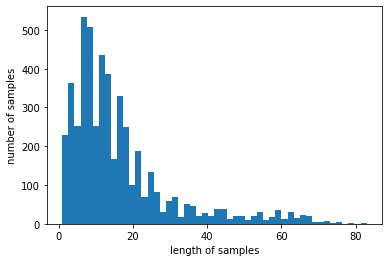

In [19]:
print('리뷰의 최대 길이 :', max(len(l) for l in X_train))
print('리뷰의 평균 길이 :', sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [20]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [21]:
max_len = 50
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 50 이하인 샘플의 비율: 95.04


In [22]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

## Train Model

In [23]:
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

### Model Architecture

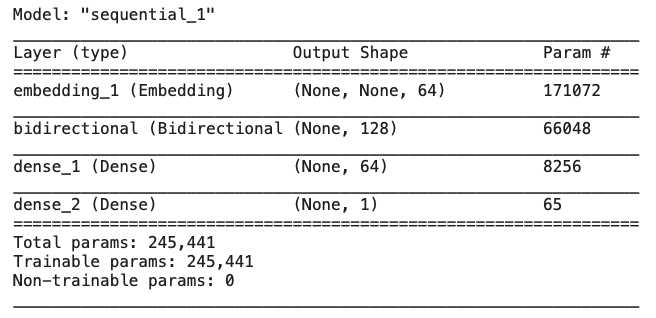

In [24]:
# model = Sequential()

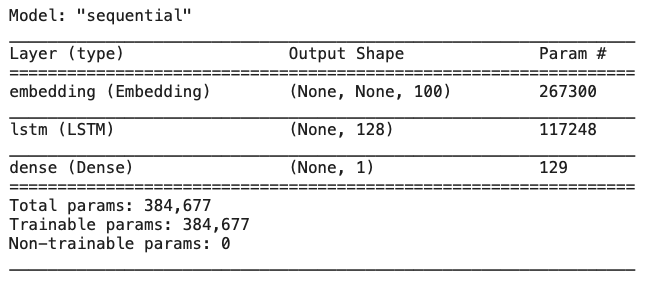

In [25]:
# model = Sequential()

In [26]:
model.summary()

NameError: ignored

- EarlyStopping: val_loss가 이전 epoch보다 증가하는 횟수를 count하고 patience만큼 count가 도달하면 학습을 멈춘다
- ModelCheckpoint: val_acc를 기준으로 이전 epoch보다 증가하면 저장한다 

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=10, callbacks=[es, mc], batch_size=60, validation_split=0.2)

## Predict sentence

In [ ]:
sentence = "영화 너무 재밌다"

preprocessed_sent = preprocess_sent(sentence)
encoded_sent = tokenizer.texts_to_sequences([preprocessed_sent])
padded_seq = pad_sequences(encoded_sent, maxlen=max_len)


In [ ]:
ckpt = load_model('best_model.h5')
score = ckpt.predict(padded_seq)
print(float(score) * 100)